In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.cuda as cuda

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Transformaciones de las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar a 224x224 recomendado para el modelo preentrenado CoAtNet
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #Normaliza la imagen con la media y desviación estándar de ImageNet
])

# Cargar los datos
train_dir = r"C:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\medicinal_plants_project\train" # Definimos la ruta del directorio de entrenamiento
test_dir = r"C:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\medicinal_plants_project\test" # Definimos la ruta del directorio de prueba

train_dataset = datasets.ImageFolder(train_dir, transform=transform) # Cargamos el conjunto de entrenamiento
test_dataset = datasets.ImageFolder(test_dir, transform=transform) # Cargamos el conjunto de prueba

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True) # Cargamos el conjunto de entrenamiento en un DataLoader
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False) # Cargamos el conjunto de prueba en un DataLoader

Using device: cuda


In [2]:
print(f"Número de imágenes en el conjunto de entrenamiento: {len(train_dataset)}")
print(f"Número de imágenes en el conjunto de prueba: {len(test_dataset)}")

# Imprimir todas las clases del conjunto de datos de entrenamiento
print("Clases en el conjunto de entrenamiento:")
print(train_dataset.classes)

Número de imágenes en el conjunto de entrenamiento: 60000
Número de imágenes en el conjunto de prueba: 15000
Clases en el conjunto de entrenamiento:
['chamaelobivia', 'hypoestes', 'lamium', 'rosario', 'sedum']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5161401..1.530268].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.6457081].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34122002..1.7241396].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.6544228].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.671852].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44764107..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..

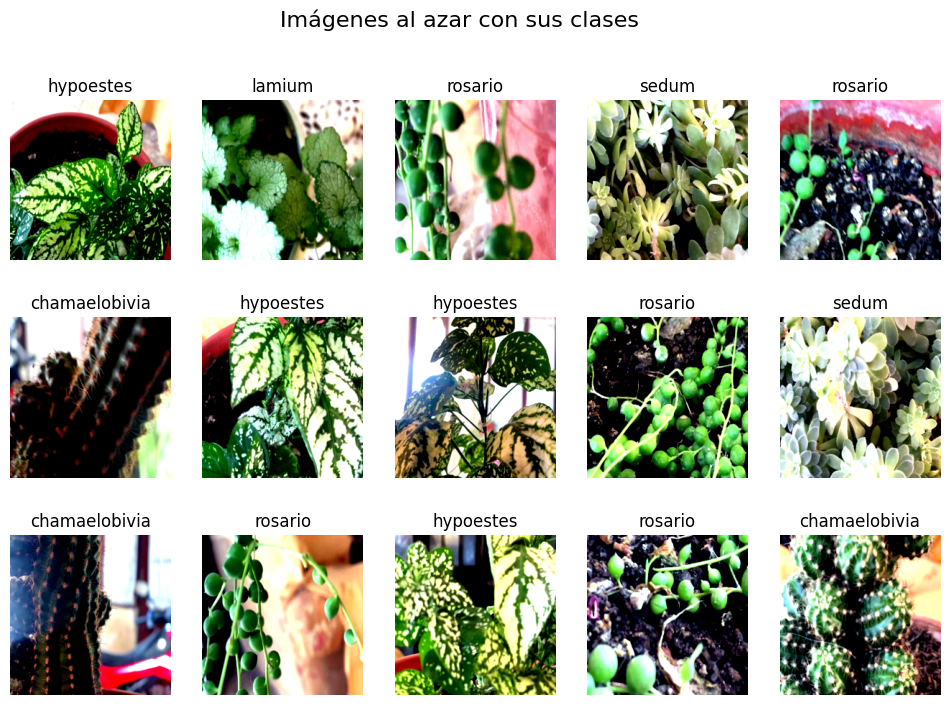

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Definimos una función para mostrar un grid de imágenes
def show_random_images(dataset, num_rows=3, num_cols=5):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))  # Creamos una figura con subplots
    fig.suptitle('Imágenes al azar con sus clases', fontsize=16)

    for i in range(num_rows):
        for j in range(num_cols):
            idx = np.random.randint(0, len(dataset))  # Seleccionamos un índice al azar
            img, label = dataset[idx]  # Obtenemos la imagen y la etiqueta
            img = img / 2 + 0.5  # Desnormalizamos la imagen
            np_img = img.numpy()  # Convertimos la imagen a un array de NumPy
            axes[i, j].imshow(np.transpose(np_img, (1, 2, 0)))  # Mostramos la imagen
            axes[i, j].set_title(dataset.classes[label])  # Mostramos la etiqueta
            axes[i, j].axis('off')  # Ocultamos los ejes

    plt.show()

# Visualizamos las imágenes al azar del conjunto de entrenamiento
show_random_images(train_dataset)

TEST PARA ENCONTRAR EL MEJOR LEARNING RATE

Crear un Subconjunto del Dataset

In [6]:
from torch.utils.data import Subset
import numpy as np

# Crear un subconjunto del dataset de entrenamiento (20% del total)
train_size = int(0.2 * len(train_dataset))
indices = np.random.choice(len(train_dataset), train_size, replace=False)
train_subset = Subset(train_dataset, indices)

# Crear DataLoader para el subconjunto
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

In [7]:
len(train_subset) # Número de imágenes en el subconjunto

12000

In [8]:
from torch.utils.data import Subset
import numpy as np

# Crear un subconjunto del dataset de entrenamiento (20% del total)
train_size = int(0.2 * len(train_dataset))
indices = np.random.choice(len(train_dataset), train_size, replace=False)
train_subset = Subset(train_dataset, indices)

# Crear DataLoader para el subconjunto
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

Modelo MLP

In [9]:
# Definición del MLP
class MLP(nn.Module): # Definimos la clase MLP que hereda de nn.Module
    def __init__(self): # Definimos el constructor de la clase
        super(MLP, self).__init__() # Llamamos al constructor de la clase padre
        self.flatten = nn.Flatten() # Aplanamos las imágenes
        self.fc1 = nn.Linear(224 * 224 * 3, 100)  # 224*224*3 entradas debido a los 3 canales RGB
        self.fc2 = nn.Linear(100, 100)  # Segunda capa oculta con 200 neuronas
        self.fc3 = nn.Linear(100, 50)   # Tercera capa oculta con 50 neuronas
        self.relu = nn.ReLU()           # Función de activación ReLU
        self.fc4 = nn.Linear(50, 5)     # Capa de salida con 5 neuronas (5 clases)


    def forward(self, x): # Definimos el método forward que recibe como parámetro las imágenes 
      
        x = self.flatten(x) # Aplanamos las imágenes
        x = self.fc1(x) # Primera capa oculta
        x = self.relu(x) # Función de activación ReLU
        x = self.fc2(x) # Segunda capa oculta
        x = self.relu(x) # Función de activación ReLU
        x = self.fc3(x) # Tercera capa oculta
        x = self.relu(x) # Función de activación ReLU
        x = self.fc4(x) # Capa de salida
        return x # x es la probabilidad de que la imagen pertenezca a cada clase

model = MLP().to(device) # Instanciamos el modelo MLP

Entrenamiento con Tasa de Aprendizaje Variable

Iter 1/100, Loss: 1.6157485246658325, LR: 1.023292992280754e-07
Iter 2/100, Loss: 1.6056370735168457, LR: 1.0471285480508996e-07
Iter 3/100, Loss: 1.6082277297973633, LR: 1.0715193052376064e-07
Iter 4/100, Loss: 1.6053425073623657, LR: 1.096478196143185e-07
Iter 5/100, Loss: 1.6161772012710571, LR: 1.1220184543019633e-07
Iter 6/100, Loss: 1.6024914979934692, LR: 1.1481536214968827e-07
Iter 7/100, Loss: 1.6104238033294678, LR: 1.1748975549395294e-07
Iter 8/100, Loss: 1.614949107170105, LR: 1.202264434617413e-07
Iter 9/100, Loss: 1.6092866659164429, LR: 1.2302687708123815e-07
Iter 10/100, Loss: 1.6020636558532715, LR: 1.2589254117941672e-07
Iter 11/100, Loss: 1.6199817657470703, LR: 1.288249551693134e-07
Iter 12/100, Loss: 1.6133170127868652, LR: 1.318256738556407e-07
Iter 13/100, Loss: 1.614530086517334, LR: 1.3489628825916535e-07
Iter 14/100, Loss: 1.6069473028182983, LR: 1.3803842646028847e-07
Iter 15/100, Loss: 1.6187313795089722, LR: 1.4125375446227544e-07
Iter 16/100, Loss: 1.61135

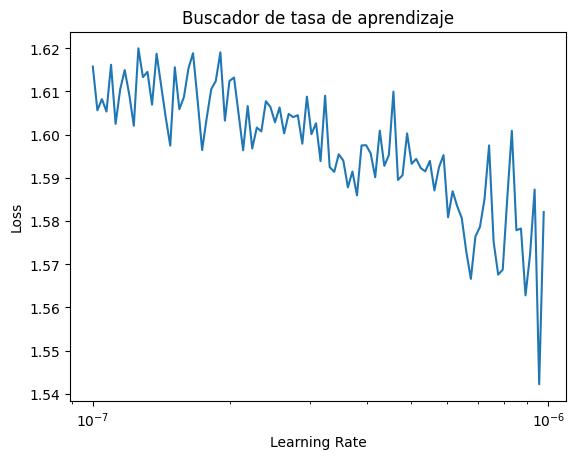

In [10]:
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

# Definir el optimizador
optimizer = optim.Adam(model.parameters(), lr=1e-7)  # Comenzar con un learning rate muy pequeño
criterion = nn.CrossEntropyLoss()

# Implementar el aprendizaje con tasa de aprendizaje variable
def find_lr(model, train_loader, criterion, optimizer, num_iters=100):
    lrs = []
    losses = []
    best_loss = float('inf')
    best_lr = None  # Variable para almacenar el mejor learning rate

    # Scheduler para incrementar el learning rate en cada batch
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 10**(epoch / num_iters))

    model.train()
    for i, (images, labels) in enumerate(train_loader):
        if i >= num_iters:
            break

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Guardar la pérdida y el learning rate actual
        lrs.append(scheduler.get_last_lr()[0])
        losses.append(loss.item())

        # Guardar el mejor valor de pérdida y el correspondiente learning rate
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_lr = scheduler.get_last_lr()[0]  # Guardar el mejor learning rate

        # Actualizar el scheduler
        scheduler.step()

        print(f"Iter {i+1}/{num_iters}, Loss: {loss.item()}, LR: {scheduler.get_last_lr()[0]}")

    print(f"Mejor Learning Rate encontrado: {best_lr}")
    return lrs, losses, best_lr

# Ejecutar la búsqueda del learning rate
lrs, losses, best_lr = find_lr(model, train_loader, criterion, optimizer, num_iters=100)

# Graficar la pérdida en función del learning rate
plt.plot(lrs, losses)
plt.xscale('log')  # Usar escala logarítmica en el eje de tasas de aprendizaje
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Buscador de tasa de aprendizaje')
plt.show()

# Guardar el mejor learning rate en un archivo
with open("best_learning_rate.txt", "w") as f:
    f.write(f"Mejor Learning Rate encontrado: {best_lr}\n")

In [11]:
print(f"Mejor Learning Rate encontrado: {best_lr}")

Mejor Learning Rate encontrado: 9.549925860214358e-07


SUBSET DE 2OMIL IMAGENES

In [12]:
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import random

# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Semilla para la reproducibilidad
random.seed(42)
torch.manual_seed(42) 

# Transformaciones de las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar a 224x224 recomendado para el modelo preentrenado CoAtNet
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normaliza la imagen con la media y desviación estándar de ImageNet
])

# Definir el tamaño del subconjunto
train_subset_size = 16000  # 80% de 10,000
test_subset_size = 4000   # 20% de 10,000

# Crear subconjuntos de índices aleatorios
train_indices = random.sample(range(len(train_dataset)), train_subset_size)
test_indices = random.sample(range(len(test_dataset)), test_subset_size)

# Crear los subconjuntos utilizando Subset
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

# Crear DataLoaders para los subconjuntos
train_loader_subset = DataLoader(train_subset, batch_size=128, shuffle=True)
test_loader_subset = DataLoader(test_subset, batch_size=128, shuffle=False)

# Imprimir el número de imágenes en cada subconjunto
print(f"Número de imágenes en el subconjunto de entrenamiento: {len(train_subset)}")
print(f"Número de imágenes en el subconjunto de prueba: {len(test_subset)}")

Using device: cuda
Número de imágenes en el subconjunto de entrenamiento: 16000
Número de imágenes en el subconjunto de prueba: 4000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4565826..1.671852].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4390787..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49901533..1.7241396].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.43051636..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5178571..1.6267507].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.5816423].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.7055

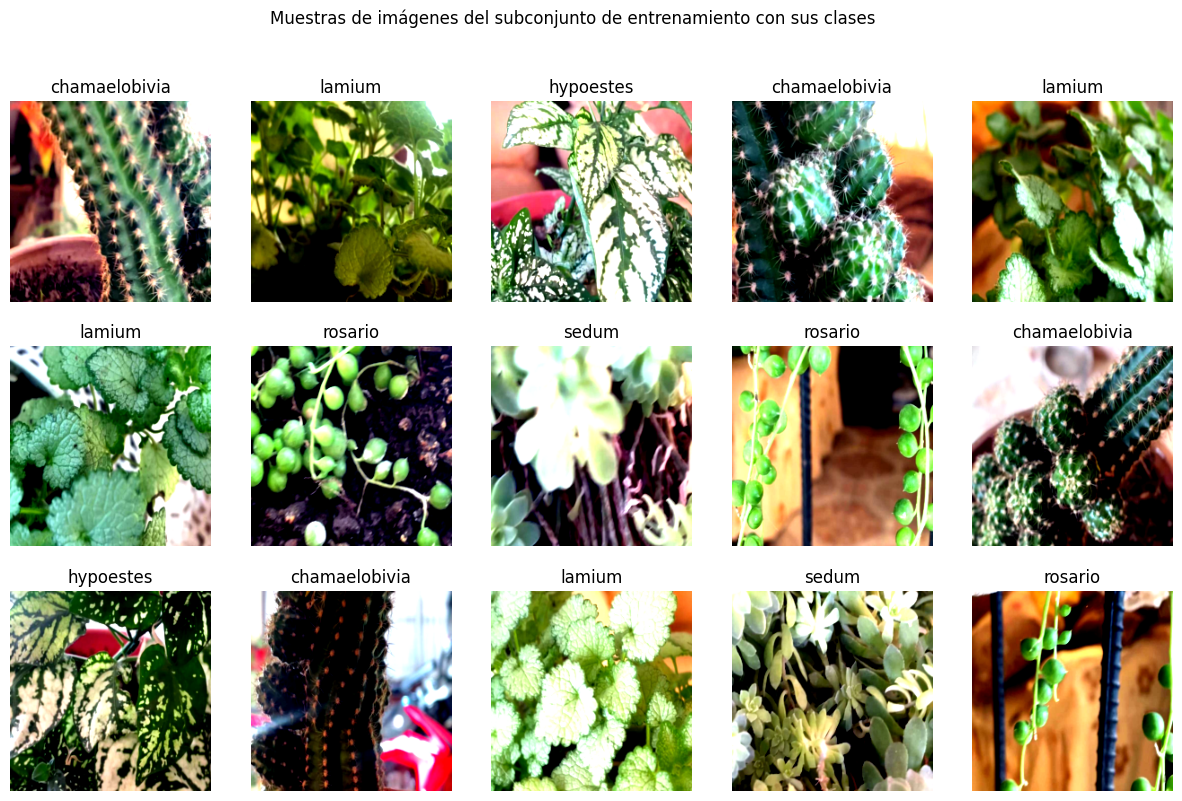

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Definir función para mostrar imágenes en un eje específico
def imshow(ax, img, title):
    """Función para mostrar una imagen con su título (clase) en un eje dado."""
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(title)
    ax.axis('off')

# Obtener nombres de clases del dataset
class_names = train_dataset.classes

# Crear un iterador para el DataLoader del subconjunto de entrenamiento
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Mostrar 3 filas y 5 columnas de imágenes
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Muestras de imágenes del subconjunto de entrenamiento con sus clases')

for i in range(3):
    for j in range(5):
        idx = i * 5 + j  # Índice de la imagen en la cuadrícula
        ax = axes[i, j]
        imshow(ax, images[idx], class_names[labels[idx]])

plt.show()

Entrenamiento from scratch

In [15]:
# Definir el modelo CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Primera capa convolucional
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max Pooling
        
        # Segunda capa convolucional
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Dropout antes de las capas fully connected
        self.dropout = nn.Dropout(p=0.5)  # Apaga el 50% de las neuronas
        
        # Capa totalmente conectada
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Redimensionar de acuerdo con la salida de las capas convolucionales
        self.fc2 = nn.Linear(128, 5)  # 5 clases

    def forward(self, x):
        # Paso por la primera capa convolucional + ReLU + Max Pooling
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        
        # Paso por la segunda capa convolucional + ReLU + Max Pooling
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        
        # Aplanar la salida para la capa fully connected
        x = x.view(x.size(0), -1)  # Aplana la salida (flatten)

        # Aplicar Dropout antes de la fully connected
        x = self.dropout(x)
        
        # Paso por la primera capa fully connected + ReLU
        x = nn.functional.relu(self.fc1(x))

        # Aplicar Dropout nuevamente
        x = self.dropout(x)
        
        # Salida final
        x = self.fc2(x)

        return x

model = SimpleCNN().to(device)

# Definir el optimizador y la función de pérdida
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=1e-4)

In [16]:
# Entrenamiento del modelo con validación en cada epoch
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Modo de entrenamiento
    running_loss = 0.0
    
    for inputs, labels in train_loader_subset:
        # Mover los datos a CUDA si está disponible
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Limpiar los gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular la pérdida
        
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar los pesos
        
        running_loss += loss.item()
    
    # Imprimir la pérdida promedio por época
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_subset):.4f}")

    # Modo de evaluación
    model.eval()
    correct = 0
    total = 0

    # Desactivar el cálculo de gradientes durante la evaluación
    with torch.no_grad():
        for inputs, labels in test_loader_subset:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calcular la precisión en el conjunto de prueba
    accuracy = 100 * correct / total
    print(f'Validation Accuracy after epoch {epoch+1}: {accuracy:.2f}%')

print("Entrenamiento completado.")

Epoch [1/10], Loss: 1.5311
Validation Accuracy after epoch 1: 63.60%
Epoch [2/10], Loss: 1.3345
Validation Accuracy after epoch 2: 68.95%
Epoch [3/10], Loss: 1.1809
Validation Accuracy after epoch 3: 71.97%
Epoch [4/10], Loss: 1.0721
Validation Accuracy after epoch 4: 75.38%
Epoch [5/10], Loss: 0.9888
Validation Accuracy after epoch 5: 76.95%
Epoch [6/10], Loss: 0.9184
Validation Accuracy after epoch 6: 78.95%
Epoch [7/10], Loss: 0.8571
Validation Accuracy after epoch 7: 80.38%
Epoch [8/10], Loss: 0.8088
Validation Accuracy after epoch 8: 81.05%
Epoch [9/10], Loss: 0.7631
Validation Accuracy after epoch 9: 81.50%
Epoch [10/10], Loss: 0.7240
Validation Accuracy after epoch 10: 83.50%
Entrenamiento completado.


Transfer Learning con CoAtNet

1. Importar y configurar el modelo CoAtNet preentrenado

In [17]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Cargar el modelo preentrenado CoAtNet desde timm
model = timm.create_model('coatnet_0_rw_224', pretrained=True, num_classes=5)

# Verificar si CUDA está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Congelar todas las capas excepto las finales
for param in model.parameters():
    param.requires_grad = False

# Descongelar las capas del clasificador para entrenar
for param in model.head.parameters():
    param.requires_grad = True

c:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\entorno_Pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2. Definir la función de pérdida y optimizador para Transfer Learning


En esta etapa, entrenamos solo las capas finales del modelo

In [18]:
# Definir el optimizador (solo para las capas del clasificador)
optimizer = optim.Adam(model.head.parameters(), lr=0.001, weight_decay=1e-4)

# Definir la función de pérdida (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

In [19]:
# Imprimir el número de imágenes en cada subconjunto
print(f"Número de imágenes en el subconjunto de entrenamiento: {len(train_subset)}")
print(f"Número de imágenes en el subconjunto de prueba: {len(test_subset)}")
#len(train_loader_subset)
#len(test_loader_subset)

Número de imágenes en el subconjunto de entrenamiento: 16000
Número de imágenes en el subconjunto de prueba: 4000


3. Entrenamiento del modelo preentrenado con Transfer Learning

In [20]:
# Transformaciones para el conjunto de entrenamiento y test
# train_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),  # Redimensionar las imágenes
#     transforms.RandomHorizontalFlip(),  # Aumento de datos
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización
# ])

# test_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# # Cargar los conjuntos de datos de entrenamiento y prueba
# train_dataset = datasets.ImageFolder('/content/plantas_dataset/train', transform=train_transforms)
# test_dataset = datasets.ImageFolder('/content/plantas_dataset/test', transform=test_transforms)

# # DataLoaders para procesar los datos en batches
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Ciclo de entrenamiento para Transfer Learning
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Modo de entrenamiento
    running_loss = 0.0
    
    for inputs, labels in train_loader_subset:
        # Mover los datos a CUDA si está disponible
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Limpiar los gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular la pérdida
        
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar los pesos
        
        running_loss += loss.item()
    
    # Imprimir la pérdida promedio por época
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_subset):.4f}")

    # Modo de evaluación
    model.eval()
    correct = 0
    total = 0

    # Desactivar el cálculo de gradientes durante la evaluación
    with torch.no_grad():
        for inputs, labels in test_loader_subset:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calcular la precisión en el conjunto de prueba
    accuracy = 100 * correct / total
    print(f'Validation Accuracy after epoch {epoch+1}: {accuracy:.2f}%')

print("Transfer Learning completado.")

c:\NC\Universidad\6° Semestre\SIS421 (INTELIGENCIA ARTIFICIAL II)\Notebooks\entorno_Pytorch\lib\site-packages\timm\models\maxxvit.py:189: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = torch.nn.functional.scaled_dot_product_attention(


Epoch [1/10], Loss: 0.1821
Validation Accuracy after epoch 1: 99.97%
Epoch [2/10], Loss: 0.0166
Validation Accuracy after epoch 2: 99.97%
Epoch [3/10], Loss: 0.0087
Validation Accuracy after epoch 3: 100.00%
Epoch [4/10], Loss: 0.0056
Validation Accuracy after epoch 4: 100.00%
Epoch [5/10], Loss: 0.0039
Validation Accuracy after epoch 5: 100.00%
Epoch [6/10], Loss: 0.0030
Validation Accuracy after epoch 6: 100.00%
Epoch [7/10], Loss: 0.0024
Validation Accuracy after epoch 7: 100.00%
Epoch [8/10], Loss: 0.0020
Validation Accuracy after epoch 8: 100.00%
Epoch [9/10], Loss: 0.0017
Validation Accuracy after epoch 9: 100.00%
Epoch [10/10], Loss: 0.0014
Validation Accuracy after epoch 10: 100.00%
Transfer Learning completado.


In [21]:
torch.save(model.state_dict(), 'mi_modelo_entrenado.pth')

In [22]:
import torch

# Libera memoria no utilizada
torch.cuda.empty_cache()

# Opción adicional para liberar los gradientes y otros recursos
del model  # Asegúrate de eliminar cualquier referencia al modelo
torch.cuda.empty_cache()

In [30]:
# Crear el modelo como durante el entrenamiento
model = timm.create_model('coatnet_0_rw_224', pretrained=False, num_classes=5)

# Cargar los pesos guardados
model.load_state_dict(torch.load('mi_modelo_entrenado.pth'))

# Mover el modelo a la GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

C:\Users\CHRISTIAN\AppData\Local\Temp\ipykernel_14136\2471056824.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mi_modelo_entrenado.pt

Fine-Tuning

1. Descongelar las capas del modelo

Primero, descongelamos las capas previamente congeladas para que puedan ser entrenadas.

In [31]:
# Descongelar capas seleccionadas para el Fine Tuning
for param in model.parameters():
    param.requires_grad = True  # Descongelar todas las capas
# Podemos descongelar solo algunas capas si lo deseas, por ejemplo, las últimas:
for name, param in model.named_parameters():
    if "block4" in name or "head" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

2. Optimizar todos los parámetros entrenables

In [32]:
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)  # Ajustamos un learning rate más bajo para Fine Tuning
# Función de pérdida
criterion = nn.CrossEntropyLoss()

In [27]:
# Crear DataLoaders para los subconjuntos
#train_loader_subset = DataLoader(train_subset, batch_size=128, shuffle=True)
#test_loader_subset = DataLoader(test_subset, batch_size=128, shuffle=False)

3. Entrenamiento de Fine-Tuning
Ahora realizamos el entrenamiento ajustando todas las capas con el optimizador configurado:

In [33]:
# Fine-Tuning del modelo
num_epochs = 10  # Puedes aumentar el número de épocas si es necesario

for epoch in range(num_epochs):
    model.train()  # Modo de entrenamiento
    running_loss = 0.0
    
    for inputs, labels in train_loader_subset:
        # Mover los datos a CUDA si está disponible
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Limpiar los gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular la pérdida
        
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar los pesos
        
        running_loss += loss.item()

        # Liberar memoria no utilizada
        torch.cuda.empty_cache()
    
    # Imprimir la pérdida promedio por época
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_subset):.4f}")

    # Evaluación del modelo tras Fine-Tuning
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader_subset:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy after epoch {epoch+1}: {accuracy:.2f}%')

print("Fine-Tuning completado.")

Epoch [1/10], Loss: 0.0012
Validation Accuracy after epoch 1: 100.00%
Epoch [2/10], Loss: 0.0012
Validation Accuracy after epoch 2: 100.00%
Epoch [3/10], Loss: 0.0012
Validation Accuracy after epoch 3: 100.00%
Epoch [4/10], Loss: 0.0011
Validation Accuracy after epoch 4: 100.00%
Epoch [5/10], Loss: 0.0011
Validation Accuracy after epoch 5: 100.00%
Epoch [6/10], Loss: 0.0011
Validation Accuracy after epoch 6: 100.00%
Epoch [7/10], Loss: 0.0010
Validation Accuracy after epoch 7: 100.00%
Epoch [8/10], Loss: 0.0010
Validation Accuracy after epoch 8: 100.00%
Epoch [9/10], Loss: 0.0010
Validation Accuracy after epoch 9: 100.00%
Epoch [10/10], Loss: 0.0010
Validation Accuracy after epoch 10: 100.00%
Fine-Tuning completado.


In [34]:
torch.save(model.state_dict(), 'mi_modelo_entrenado_con_fineTuning.pth')

In [35]:
import torch

# Libera memoria no utilizada
torch.cuda.empty_cache()

# Opción adicional para liberar los gradientes y otros recursos
#del model  # Asegúrate de eliminar cualquier referencia al modelo
#torch.cuda.empty_cache()

Matriz de Confusión

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot matriz de confusión
plot_confusion_matrix(model, test_loader, class_names)


ModuleNotFoundError: No module named 'seaborn'